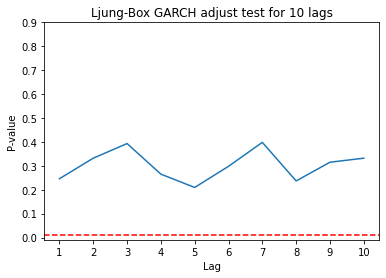

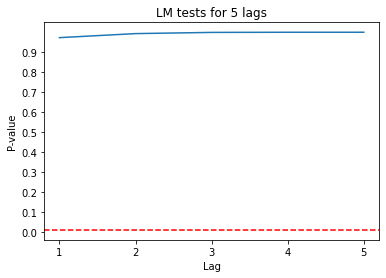

In [1]:
import sqlalchemy as db
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

data_path  = r'C:\Users\Lazar\Desktop\Financial Volatility'

                        
data_path  = r'C:\Users\Lazar\Desktop\Financial Volatility\Assignment'

# create connection to sqlite database
db_path = os.path.join(data_path, 'database.db')
db_engine = db.create_engine('sqlite:///' + db_path)

# select your desired table 
data = pd.read_sql("select *from returns", db_engine)

def gamma(x,h):
  n=len(x)
  h=abs(h)
  x = x-x.mean()
  gy = np.multiply(np.asarray(x[0:(n-h)]),x[h:(n)])
  gamma= (gy.sum()).item()/n
  return gamma

def rho(x,h):
  rho = gamma(x,h)/gamma(x,0)
  return rho

def gamma_asy(x,h):
    '''

    Parameters
    ----------
    x : pd.Series
        Time series of stock return.
    h : nummeric.
        Number of lags to be included in the matrix. For example, 5.
    Returns
    -------
    Assymetric cov.matrix of the sample autocorrelation.

    '''
    n = len(x)
    h = abs(h)
    x = x - x.mean()
    x2 = x**2
    gamma_asy = np.empty((h,h))
    gamma_asy[:] = np.nan
    for i in (range(0,h)):
        for j in (range(i,h)):
            gamma_asy[i,j] = np.multiply(np.asarray(x[(j-i):(n-i-1)]),np.multiply(np.asarray(x[0:(n-j-1)]),np.asarray(x2[(j+1):(n)]))).sum()/n
            gamma_asy[j,i] = gamma_asy[i,j] 
    rho_asy = np.multiply((1/gamma(x,0)**2),gamma_asy)
    return gamma_asy, rho_asy

def corr_Box_test(x,h, print_res = True):
    '''

    Parameters
    ----------
    x : pd.Series
        DESCRIPTION.
    h : nummeric
        Number of lags to be included in the matrix. For example, 5.
    print_res : Bool.
        Specifies whether results should be printed.

    Returns
    -------
     Corrected portmanteau test under GARCH assumption for the hth lag.

    '''

    n = len(x)
    a = gamma_asy(x,h)
    acf_val = np.empty((1,h))
    acf_val[:] = np.nan
    for i in range(0,h):
        acf_val[0,i] = rho(x,i+1)
    val = n*np.dot(np.dot(acf_val, np.linalg.inv(a[1])), acf_val.T)
    if print_res is True:
        print(val, (1 - stats.chi2.cdf(val, h)))
    return(val, (1 - stats.chi2.cdf(val, h)))
    



def corr_Box_plot(x,h, print_res = False, sig_level = 0.01):
    '''

    Parameters
    ----------
    x : pd.Series
        DESCRIPTION.
    h : nummeric
        Number of lags to be included in the matrix. For example, 5.
    print_res : Bool.
        Specifies whether results should be printed.
    sig_level : nummeric
        Sets the critical bound for significance of the p-values. Default is 0.01.

    Returns
    -------
     Corrected portmanteau test under GARCH assumption for the hth lag. 
     Results are also plotted using matplotlib.

    '''
    plt_val = np.empty((h,2))
    plt_val[:] = np.nan
    for i in range(0,h):
        plt_val[i , 0], plt_val[i , 1] = corr_Box_test(x, i + 1, print_res = False)
    plt.plot(np.linspace(1, h, h), plt_val[:,1])
    plt.axhline(y=sig_level, color='r', linestyle='--')
    plt.xticks(np.arange(1, h+1, step=1))
    plt.yticks(np.arange(0,1, step = 0.1))
    plt.ylabel('P-value')
    plt.xlabel('Lag')
    plt.title('Ljung-Box GARCH adjust test for {0} lags'.format(h))
    plt.show()

corr_Box_plot(data['EEM'], 10)


def LM_test(x,h, print_res = True):
    n = len(x)
    x_2 = x**2-np.mean(x**2)
    dat = np.empty((n-h, h+1))
    dat[:] = np.nan
    for i in range(0, h+1):
        dat[:,i] = np.asarray(x_2[(h-i):(n-i)]).flatten()
    model = sm.OLS(dat[:,0], sm.add_constant(dat[:,1:(h+1)]))
    results = model.fit()
    results.summary()
    r2 = results.rsquared
    if print_res is False:
        pass
    elif print_res is True:
        print(r2*n, (1 - stats.chi2.cdf(r2*n, h)))
    return r2*n, (1 - stats.chi2.cdf(r2*n, h))

def LM_test_plot(x,h, sig_level):
    plt_val = np.empty((h,2))
    plt_val[:] = np.nan
    for i in range(0,h):
        plt_val[i , 0], plt_val[i , 1] = LM_test(x, i + 1, print_res = False)
    plt.plot(np.linspace(1, h, h), plt_val[:,1])
    plt.axhline(y=sig_level, color='r', linestyle='--')
    plt.xticks(np.arange(1, h+1, step=1))
    plt.yticks(np.arange(0,1, step = 0.1))
    plt.ylabel('P-value')
    plt.xlabel('Lag')
    plt.title('LM tests for {0} lags'.format(h))
    plt.show()

LM_test_plot(data['EEM'], 5, sig_level = 0.01)

